# Calculate Customer Lifetime Value

In [1]:
#Import necessary libraries
import pandas as pd
import matplotlib as plt

#Import Data
tx_data=pd.read_excel("RetailData.xlsx")
tx_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
#Check the shape (number of columns and rows) in the dataset
tx_data.shape

(541909, 8)

In [3]:
#Find out missing values
tx_data.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
#Remove time from date
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'], format="%m/%d/%Y %H:%M").dt.date

#There are 135,080 missing values in the CustomerID column, and since our analysis is based on customers, 
#we will remove these missing values.
tx_data = tx_data[pd.notnull(tx_data['CustomerID'])]

#Keep records with non negative quantity
tx_data = tx_data[(tx_data['Quantity']>0)]

#Add a new column depicting total sales
tx_data['Total_Sales'] = tx_data['Quantity'] * tx_data['UnitPrice']
necessary_cols = ['CustomerID', 'InvoiceDate', 'Total_Sales']
tx_data = tx_data[necessary_cols]
tx_data.head()

,CustomerID,InvoiceDate,Total_Sales
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34


In [5]:
#Print records pertaining unique Customer IDs
print(tx_data['CustomerID'].nunique())

4339


In [6]:
#Check the Last order date
last_order_date = tx_data['InvoiceDate'].max()
print(last_order_date)
print("--------------------------------------")
print(tx_data[(tx_data['CustomerID']==12346)])
print("--------------------------------------")
print(tx_data[(tx_data['CustomerID']==12347)].tail())
print("--------------------------------------")
print(tx_data[(tx_data['CustomerID']==12347)]['InvoiceDate'].max(), tx_data[(tx_data['CustomerID']==12347)]['InvoiceDate'].min())


2011-12-09
--------------------------------------
       CustomerID InvoiceDate  Total_Sales
61619     12346.0  2011-01-18      77183.6
--------------------------------------
        CustomerID InvoiceDate  Total_Sales
535010     12347.0  2011-12-07         8.50
535011     12347.0  2011-12-07        23.40
535012     12347.0  2011-12-07        13.28
535013     12347.0  2011-12-07         8.40
535014     12347.0  2011-12-07         8.40
--------------------------------------
2011-12-07 2010-12-07


In [7]:
from datetime import datetime
number_of_purchases = tx_data[(tx_data['CustomerID']==12347)]['InvoiceDate'].nunique()
first_time_purchase = tx_data[(tx_data['CustomerID']==12347)]['InvoiceDate'].min()
recent_purchase = tx_data[(tx_data['CustomerID']==12347)]['InvoiceDate'].max()


frequency = number_of_purchases-1
recency = recent_purchase - first_time_purchase
T = last_order_date - first_time_purchase

print("The R, F, T")
print('---------')
print("Frequency ->",frequency)
print("Recency ->", recency)
print("T(Life Span of the user) ->", T)

The R, F, T
---------
Frequency -> 6
Recency -> 365 days, 0:00:00
T(Life Span of the user) -> 367 days, 0:00:00


In [10]:
from lifetimes.plotting import *
from lifetimes.utils import *
#Built-in utility functions from lifetimes package to transform the transactional data (one row per purchase) 
#into summary data (a frequency, recency, age and monetary).

lf_tx_data = summary_data_from_transaction_data(tx_data, 'CustomerID', 'InvoiceDate', monetary_value_col='Total_Sales', observation_period_end='2011-12-9')
lf_tx_data.reset_index().head()

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667
2,12348.0,3.0,283.0,358.0,301.480000
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000


count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
---------------------------------------
Percentage of customers purchase the item only once: 35.7 %


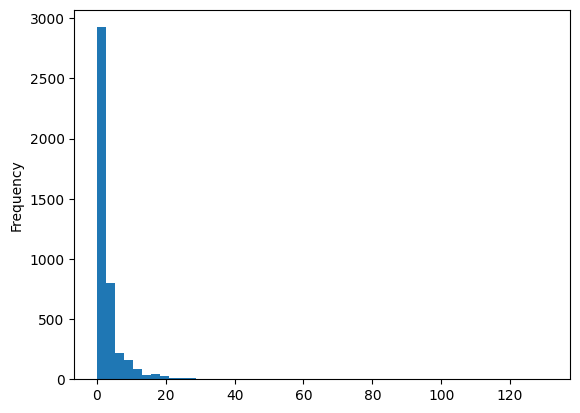

In [11]:
%matplotlib inline
#Create histogram to find out how many customers purchased item only once.
lf_tx_data['frequency'].plot(kind='hist', bins=50)
print(lf_tx_data['frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(lf_tx_data['frequency'] == 0)/float(len(lf_tx_data))*(100),2)
print("Percentage of customers purchase the item only once:", one_time_buyers ,"%")

In [12]:
#Frequency/Recency Analysis Using the BG/NBD Model
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(lf_tx_data['frequency'], lf_tx_data['recency'], lf_tx_data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


In [13]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826433,0.026780,0.773944,0.878922
alpha,68.890678,2.611055,63.773011,74.008345
a,0.003443,0.010347,-0.016837,0.023722
b,6.749363,22.412933,-37.179985,50.678711


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

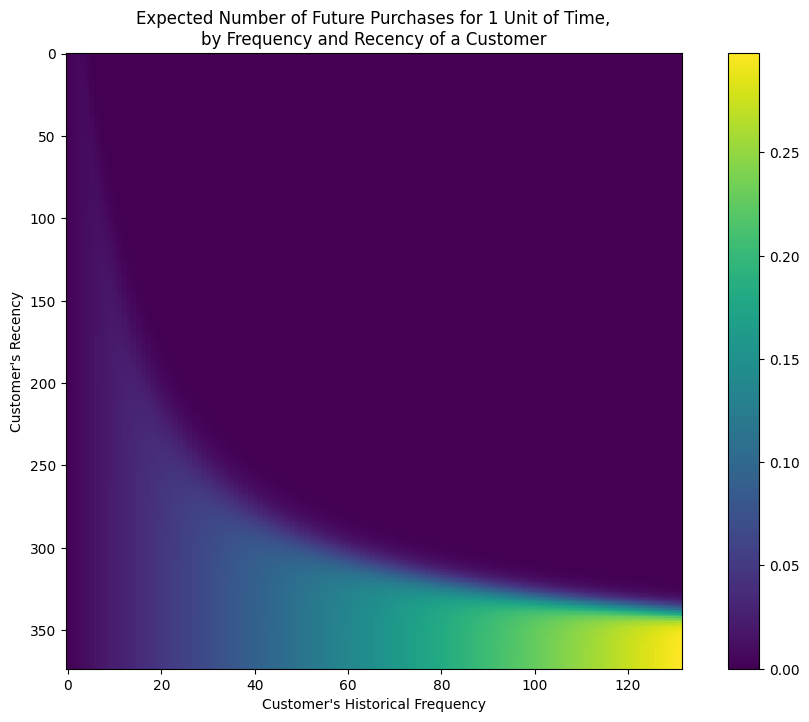

In [14]:
#Visualizing our frequency/recency matrix
%matplotlib inline
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_frequency_recency_matrix
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

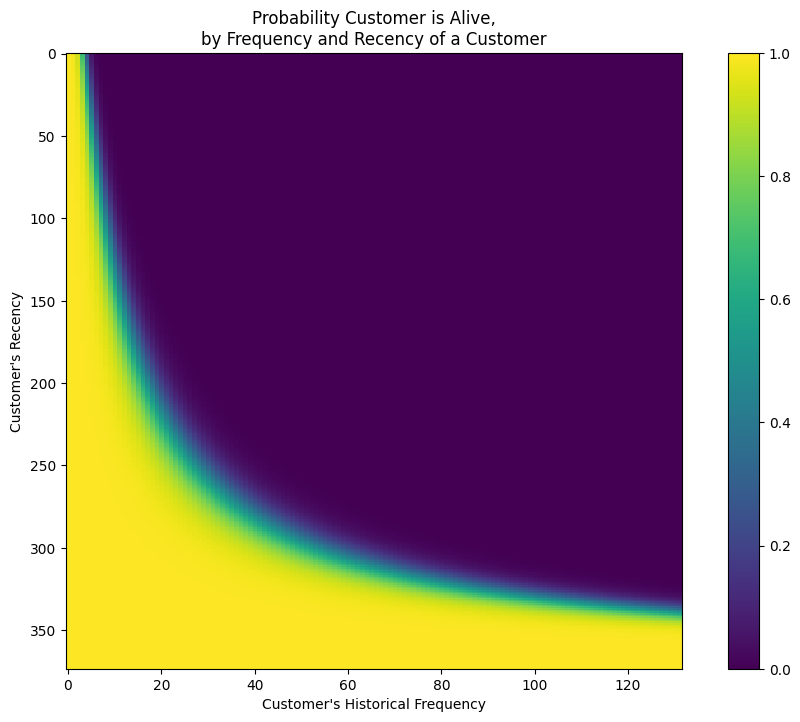

In [15]:
#predict if the customers are surely alive:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [16]:
#Predict future transaction in next 10 days i.e.top 10 customers that the model expects them to make purchases 
#in the next 10 days, based on historical data

t = 10
lf_tx_data['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, lf_tx_data['frequency'], lf_tx_data['recency'], lf_tx_data['T']),2)
lf_tx_data.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index()

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn
0,14911.0,131.0,372.0,373.0,1093.661679,2.98
1,12748.0,113.0,373.0,373.0,298.360885,2.58
2,17841.0,111.0,372.0,373.0,364.452162,2.53
3,15311.0,89.0,373.0,373.0,677.729438,2.03
4,14606.0,88.0,372.0,373.0,135.890114,2.01
5,12971.0,70.0,369.0,372.0,159.211286,1.61
6,13089.0,65.0,367.0,369.0,893.714308,1.50
7,14527.0,53.0,367.0,369.0,155.016415,1.23
8,13798.0,52.0,371.0,372.0,706.650962,1.20
9,16422.0,47.0,352.0,369.0,702.472340,1.09


<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

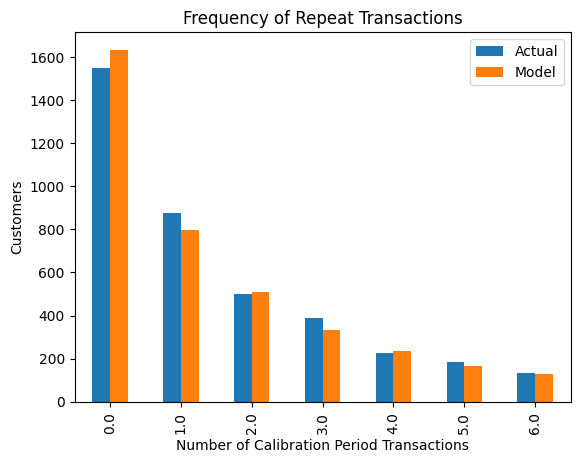

In [17]:
#Assessing model fit
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [18]:
#Customer's future transaction prediction for next 10 days

t = 10
individual = lf_tx_data.loc[14911]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

#OBSERVATION: Our model predicts that customer 14911’s future transaction is appx 3 in 10 days.

2.9830238639041133

In [19]:
#Check if there is correlation between monetary value and frequency in order to use gamma gamma model for CLV calculation.
lf_tx_data[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.046161
frequency,0.046161,1.000000


In [20]:
#Shortlist customers who had at least one repeat purchase with the company. 
shortlisted_customers = lf_tx_data[lf_tx_data['frequency']>0]
print(shortlisted_customers.head().reset_index())
print("-----------------------------------------")
print("The Number of Returning Customers are: ",len(shortlisted_customers))

   CustomerID  frequency  recency      T  monetary_value  pred_num_txn
0     12347.0        6.0    365.0  367.0      599.701667          0.16
1     12348.0        3.0    283.0  358.0      301.480000          0.09
2     12352.0        6.0    260.0  296.0      368.256667          0.19
3     12356.0        2.0    303.0  325.0      269.905000          0.07
4     12358.0        1.0    149.0  150.0      683.200000          0.08
-----------------------------------------
The Number of Returning Customers are:  2790


In [21]:
#Train gamma-gamma model by taking into account the monetary_value.
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(shortlisted_customers['frequency'],
        shortlisted_customers['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


In [22]:
#After applying Gamma-Gamma model, now we can estimate average transaction value for each customer. 
print(ggf.conditional_expected_average_profit(
        lf_tx_data['frequency'],
        lf_tx_data['monetary_value']
    ).head(10))

CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
12352.0    376.166864
12353.0    416.917667
12354.0    416.917667
12355.0    416.917667
12356.0    324.008941
dtype: float64


In [23]:
lf_tx_data['pred_txn_value'] = round(ggf.conditional_expected_average_profit(
        lf_tx_data['frequency'],
        lf_tx_data['monetary_value']), 2)
lf_tx_data.reset_index().head()

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn,pred_txn_value
0,12346.0,0.0,0.0,325.0,0.000000,0.02,416.92
1,12347.0,6.0,365.0,367.0,599.701667,0.16,569.99
2,12348.0,3.0,283.0,358.0,301.480000,0.09,333.76
3,12349.0,0.0,0.0,18.0,0.000000,0.10,416.92
4,12350.0,0.0,0.0,310.0,0.000000,0.02,416.92


In [24]:
#Calculate Customer Lifetime Value
lf_tx_data['CLV'] = round(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    lf_tx_data['frequency'],
    lf_tx_data['recency'],
    lf_tx_data['T'],
    lf_tx_data['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
), 2)

#lf_tx_data.drop(lf_tx_data.iloc[:, 0:6], inplace=True, axis=1)

lf_tx_data.sort_values(by='CLV', ascending=False).head(5).reset_index()

,CustomerID,frequency,recency,T,monetary_value,pred_num_txn,pred_txn_value,CLV
0,14646.0,44.0,353.0,354.0,6366.705909,1.06,6213.28,222128.93
1,18102.0,25.0,367.0,367.0,9349.477200,0.59,8951.86,178895.33
2,16446.0,1.0,205.0,205.0,168469.600000,0.07,78051.29,175531.47
3,17450.0,26.0,359.0,367.0,7404.690385,0.62,7105.09,147476.62
4,14096.0,16.0,97.0,101.0,4071.434375,0.99,3823.47,127589.20


In [25]:
#12744.0	5.0	267.0	318.0	3845.244000	0.15	3197.54	16234.77
temp = tx_data[tx_data['CustomerID'] == 12744.0].groupby('InvoiceDate').agg({'Total_Sales':['sum']})

In [26]:
total = temp[temp.columns.tolist()[0]].sum()

In [27]:
pred = 3197.54*0.15

In [28]:
total+pred

21758.921000000002